In [1]:
import numpy as np
import json
import csv
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import re
from IPython.display import display
from efficient_apriori import apriori
import matplotlib.pyplot as plt
from tqdm import tqdm
import collections
from efficient_apriori import apriori
import networkx as nx
import inflect

In [2]:
engine = inflect.engine()

In [3]:
with open('data/kaggle/train.json') as f:
    data = json.load(f)
with open('data/kaggle/test.json') as f:
    data_test = json.load(f)
with open('data/nationalities.csv', 'r') as f:
    reader = csv.reader(f)
    nationalities = [item.lower() for sublist in list(reader)[1:] for item in sublist]
with open('data/to_remove.csv', 'r') as f:
    reader = csv.reader(f)
    to_remove = [item.lower() for sublist in list(reader) for item in sublist]

In [4]:
baseURL = "https://en.wikipedia.org/wiki/"

ingr_size = list(['small', 'medium', 'large', 'big', 'flat'])

ingr_parts = list(['breast','breasts', 'tender', 'tenders', 'ribs', 'shoulder', 'fillet',
                   'steak', 'tigh', 'liver', 'livers',
                   'clove', 'cloves', 'leaf', 'leaves', 'flakes', 'threads', 'paste',
                   'piece', 'pieces', 'slice', 'slices', 'crumbles', 'powder', 'blend', 'mix'])

ingr_state = list(['grilled', 'roasted', 'toasted', 'fried', 'baked', 'cooked',
              'chopped', 'cut', 'sliced', 'shredded',
              'frozen', 'refrigerated', 'fresh', 'freshly', 'organic', 'natural', 'active',
              'boneless', 'skinless', 'condensed', 'ground', 'warm', 'cold'])

ingr_color = list(['purple', 'yellow', 'blue', 'red', 'white', 'black', 'green', 'brown'])

#to_remove_step1 = ingr_size+ingr_parts+ingr_state
to_remove_step2 = ingr_color



to_remove_step1  = list(['crumbles', 'ground', 'grilled', 'roasted', 'toasted', 'fried', 'baked', 'chopped',
                         'frozen', 'refrigerated', 'boneless', 'natural', 'organic', 'fresh', 'freshly',
                         'medium', 'large','big', 'small', 'breasts', 'tender', 'ribs', 'shoulder', 'paste', 'cloves', 'slivered',
                         'condensed', 'cut', 'piece', 'pieces', 'sliced', 'cooked', 'grated'])
to_remove_step2  = list(['purple', 'yellow', 'blue', 'red', 'white', 'black', 'green', 'dried'])

In [5]:
"""def try_find_ingredient2(ingr_list):
    ingr = '+'.join(ingr_list)
    str1 = "Went to foodDB for: "+ingr+" -> "
    try:
        url = urlopen(baseURL2+ingr)
    except:
        return ""
    res = BeautifulSoup(url.read(),"html5lib");
    title = res.find(class_= "hit-name").text.lower()
    title = re.sub(r" \(.*\)","", title)
    join = [value for value in title.split() if value in ingr_list]
    if len(join) > 0:
        title = ' '.join(join)
    print(str1+title)
    return title"""

def try_find_ingredient(ingr_list):
    ingr = '_'.join(ingr_list)
    try:
        url = urlopen(baseURL+ingr)
    except:
        return ""
    res = BeautifulSoup(url.read(),"html5lib");
    title = res.find(id="firstHeading").text.lower()
    title = re.sub(r" \(.*\)","", title) #remove (desambiguation)
    return title

In [6]:
"""def clean_ingredient(ingr):
    ingr = ingr.split(',')[0].split('(')[0].replace('%', "").lower()
    ingredient_list = [ing for ing in ingr.split() if (ing not in nationalities and not ing.isdigit()) ]
    ingredient = try_find_ingredient(ingredient_list)
    if ingredient == "":
        ingredient_list = [word for word in ingredient_list if (word not in to_remove)]
        ingredient = try_find_ingredient(ingredient_list)
        if ingredient == "":
            ingredient = ' '.join(ingredient_list)
        else:
            print('FOUND AT 2ND SEARCH')
    return ingredient"""

def clean_ingredient(ingr):
    ingr = re.sub(r'\([^)]*\)','', ingr)
    ingr = ingr.split(',')[0].replace('%', "").lower()
    ingredient_list = [ing for ing in ingr.split() if (ing not in nationalities and not ing.isdigit()) ]
    ingredient = ""
    if ingredient == "":
        ingredient_list = [word for word in ingredient_list if (word not in to_remove)]
        ingredient = ' '.join(ingredient_list)
    return ingredient

In [7]:
def get_ingredients_from_recipe(recipe):
    ingredients = set()
    for ingr in recipe['ingredients']:
        cleaned_ingr = clean_ingredient(ingr)
        if cleaned_ingr == "" and 'leaves' in ingr:
            cleaned_ingr = 'lettuce'
        if cleaned_ingr == "" and ingr == 'boneless, skinless chicken breast':
            cleaned_ingr = 'chicken breasts'
        if cleaned_ingr:
            ingredients.add(cleaned_ingr)
            
    return list(ingredients)

In [8]:
def print_ingredients_from_recipe(recipe):
    table = list()
    for ingr in recipe['ingredients']:
        cleaned_ingr = clean_ingredient(ingr)
        table.append((ingr, cleaned_ingr))
    df = pd.DataFrame.from_records(table, columns=['from', 'to'])
    display(df)

In [9]:
len(data)

39774

In [10]:
%%time
table = list()
for recipe in tqdm(data):
    ingredients = get_ingredients_from_recipe(recipe)
    #table.append(ingredients)
    for ingr in ingredients:
        table.append(ingr)
for recipe in tqdm(data_test):
    ingredients = get_ingredients_from_recipe(recipe)
    #table.append(ingredients)
    for ingr in ingredients:
        table.append(ingr)

100%|████████████████████████████████████| 9944/9944 [00:01<00:00, 7668.11it/s]


Wall time: 6.55 s


In [11]:
se = pd.Series(table)

[]

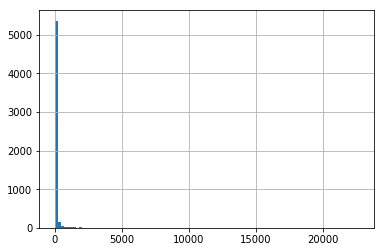

In [12]:
df_count = se.value_counts()
df_count.hist(bins=100)
plt.plot()

In [13]:
(df_count[df_count>=4].sum()) / df_count.sum()

0.992393350946885

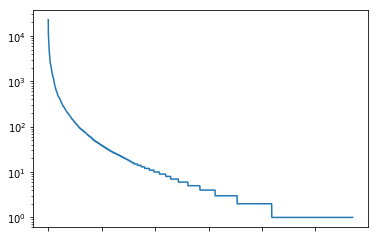

In [14]:
df_count.plot(logy = True)

In [15]:
frequent_ingr = df_count[df_count>=4].index.tolist()

In [16]:
len(frequent_ingr)

3121

In [17]:
recipes_clean = list()
for recipe in tqdm(data):
    ingredients = get_ingredients_from_recipe(recipe)
    ingredients = [ingr for ingr in ingredients if ingr in frequent_ingr]
    recipes_clean.append(tuple(ingredients))
    
for recipe in tqdm(data_test):
    ingredients = get_ingredients_from_recipe(recipe)
    ingredients = [ingr for ingr in ingredients if ingr in frequent_ingr]
    recipes_clean.append(tuple(ingredients))

100%|████████████████████████████████████| 9944/9944 [00:01<00:00, 5174.43it/s]


In [18]:
for recipe in range(len(recipes_clean)):
    recipes_clean[recipe] = list(recipes_clean[recipe])
    for ingr in range(len(recipes_clean[recipe])):
        if engine.singular_noun(recipes_clean[recipe][ingr]):
            recipes_clean[recipe][ingr] = engine.singular_noun(recipes_clean[recipe][ingr])
recipes_clean

[['grape tomato',
  'garlic',
  'seasoning',
  'feta cheese',
  'pepper',
  'purple onion',
  'black olife',
  'garbanzo bean',
  'romaine lettuce'],
 ['green tomato',
  'black pepper',
  'plain flour',
  'thyme',
  'yellow corn meal',
  'salt',
  'vegetable oil',
  'pepper',
  'egg',
  'tomato',
  'milk'],
 ['yellow onion',
  'chicken liver',
  'butter',
  'green chily',
  'chicken breast',
  'garlic powder',
  'cooking oil',
  'soy sauce',
  'mayonaise',
  'salt',
  'pepper',
  'egg'],
 ['wheat', 'vegetable oil', 'water', 'salt'],
 ['double cream',
  'lemon juice',
  'garlic',
  'cornflour',
  'yogurt',
  'milk',
  'oil',
  'water',
  'onion',
  'chicken thigh',
  'black pepper',
  'butter',
  'salt',
  'bay',
  'passata',
  'garam masala',
  'shallot',
  'cayenne pepper',
  'cumin',
  'chili powder'],
 ['vanilla',
  'ginger',
  'butter',
  'plain flour',
  'powdered sugar',
  'ginger root',
  'sugar',
  'cinnamon',
  'salt',
  'baking powder',
  'egg',
  'milk'],
 ['olive oil',
  'c

### Apriori implementation

In [19]:
%%time
itemsets, rules = apriori(recipes_clean, min_support=0.005,  min_confidence=0.4)

Wall time: 4min 58s


### What are the ingredients part of the rules ?

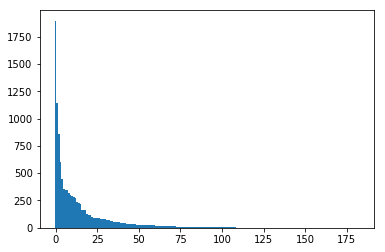

20 most common ingredients :


[('salt', 1895),
 ('onion', 1146),
 ('garlic', 859),
 ('tomato', 600),
 ('olive oil', 448),
 ('ginger', 358),
 ('cilantro', 347),
 ('cumin', 347),
 ('black pepper', 321),
 ('water', 301),
 ('egg', 289),
 ('all-purpose flour', 286),
 ('soy sauce', 272),
 ('sugar', 237),
 ('garlic clove', 228),
 ('pepper', 216),
 ('baking powder', 165),
 ('parsley', 159),
 ('sesame oil', 159),
 ('chili powder', 122)]

In [20]:
ing = collections.Counter()
for r in rules :
    ing.update(list(r.lhs))
    ing.update(list(r.rhs))
    
labels, values = zip(*ing.most_common())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
#plt.xticks(indexes + width * 0.5, labels)
plt.show()

print("20 most common ingredients :")
ing.most_common(20)